In [1]:
input_path = '../output/gigaword-dev.2018-05-10-7d764e7.npz'
word_vocab_path = '../output/vocab.2018-05-10-7d764e7.pkl'

In [2]:
import sys
if '..' not in sys.path: sys.path.append('..')

In [3]:
from convert_mono2hdn import monosemous_noun2related_hdns
from hdn import extract_all_hdns

## We first explore the distribution of monosemous nouns and the evidence they provide for WSD

In [4]:
all_hdns = extract_all_hdns()
mono2hdn = monosemous_noun2related_hdns(all_hdns)

Looking for HDNs: 100%|██████████| 119034/119034 [00:28<00:00, 4193.70lemma/s]


Looking for monosemous nouns... Done.
All noun lemmas: 119034
Monosemous noun lemmas: 65849 (55.3%)
Monosemous multi-word-expressions: 39445 (59.9% of monosemous)
	Samples: art_deco, angular_shape, nasal_canthus, loop_knot, genus_Chaenomeles
Lemmas that are not associated with any HDN: physical_entity, whacker, freshener, otherworld, entity, abstract_entity
Number of HDNs per lemma: mean=5.2, median=5.0, std=2.0)


In [5]:
import numpy as np
word2id = np.load(word_vocab_path)

In [6]:
in_vocab_monos = list(set(mono2hdn).intersection(word2id))

In [7]:
from random import sample
sample(in_vocab_monos, 100)

['convertor',
 'lysine',
 'thistledown',
 'macroeconomist',
 'oxidizer',
 'stronghold',
 'urokinase',
 'adieu',
 'arteriogram',
 'phenylephrine',
 'eyepatch',
 'locality',
 'beverage',
 'niobium',
 'sebum',
 'fractal',
 'jabot',
 'shaheed',
 'palimony',
 'bloodbath',
 'chumminess',
 'snowfall',
 'attainability',
 'chlorpyrifos',
 'pornography',
 'brainchild',
 'referendum',
 'collard',
 'bystander',
 'disinheritance',
 'trafficker',
 'grunge',
 'salicylate',
 'potluck',
 'crasher',
 'consul',
 'goitre',
 'murre',
 'constructivism',
 'trader',
 'bellower',
 'gunfight',
 'vegetarianism',
 'paedophilia',
 'dell',
 'bookishness',
 'polyethylene',
 'preordination',
 'desuetude',
 'taxman',
 'cathedra',
 'endodontics',
 'untrustworthiness',
 'minibar',
 'liter',
 'potholer',
 'liberalisation',
 'centrefold',
 'diadem',
 'rectory',
 'dampener',
 'abetment',
 'picnicker',
 'gossipmonger',
 'staphylococcus',
 'sarcophagus',
 'canoeist',
 'dyer',
 'chasuble',
 'offender',
 'amorality',
 'moderni

In [8]:
print(len(in_vocab_monos), '/', len(mono2hdn))

14226 / 65849


In [9]:
from generate_hdn_datasets import *
mono2evidence = extract_evidences(mono2hdn, all_hdns)

100%|██████████| 65849/65849 [01:50<00:00, 593.92it/s]

Found 39433602 evidences, ignored 387125 conflicts


In [10]:
from collections import Counter
c = Counter(e['candidates'] 
            for evidences in tqdm(mono2evidence.values()) 
            for e in evidences)

100%|██████████| 65843/65843 [00:32<00:00, 2051.74it/s]


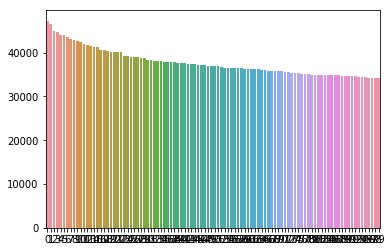

In [11]:
%matplotlib inline
import seaborn as sns

n = 100
sns.barplot(list(range(n)), [cnt for _, cnt in c.most_common(n)])

In [12]:
from evaluate.wn_utils import synset2identifier
from nltk.corpus import wordnet as wn

id2synset = {synset2identifier(ss, '30'): ss for ss in  wn.all_synsets('n')}

In [13]:
from random import sample
for _ in range(10):
    lemma, = sample(in_vocab_monos, 1)
    evidence, = sample(mono2evidence[lemma], 1)
    print('%s:' %lemma)
    for cand in evidence['candidates']:
        print('\t%s' %id2synset[cand].name())
    print('\t--> %s' %id2synset[evidence['hdn']].name())

landline:
	whole.n.02
	matter.n.03
	psychological_feature.n.01
	location.n.01
	group.n.01
	relation.n.01
	figure.n.06
	circle.n.03
	--> whole.n.02
intubation:
	object.n.01
	psychological_feature.n.01
	group.n.01
	measure.n.02
	chemical.n.01
	paper.n.01
	--> psychological_feature.n.01
resin:
	object.n.01
	matter.n.03
	artifact.n.01
	location.n.01
	diversion.n.01
	work.n.01
	property.n.02
	happening.n.01
	solid.n.03
	--> matter.n.03
harridan:
	causal_agent.n.01
	cognition.n.01
	attribute.n.02
	event.n.01
	process.n.06
	--> causal_agent.n.01
pachyderm:
	thing.n.12
	object.n.01
	natural_object.n.01
	--> object.n.01
toluene:
	substance.n.01
	substance.n.07
	psychological_feature.n.01
	communication.n.02
	--> substance.n.01
inaccuracy:
	attribute.n.02
	relation.n.01
	community.n.06
	gathering.n.01
	organization.n.01
	--> attribute.n.02
baboon:
	animal.n.01
	plant.n.02
	matter.n.03
	artifact.n.01
	psychological_feature.n.01
	measure.n.02
	peer.n.01
	worker.n.01
	friend.n.01
	relative.n.01
	--

## Now we would explore the evidences in context

In [14]:
import numpy as np

In [15]:
arrs = np.load(input_path)

In [16]:
sent_index, buffer = arrs['sent_index'], arrs['buffer']

In [17]:
id2word = {i: w for w, i in word2id.items()}

In [18]:
mono_as_ids = set(word2id[w] for w in in_vocab_monos)

In [19]:
mono_in_sent = [{'sent': s, 'word': w} 
                for s, (start, end) in enumerate(tqdm(sent_index))
                for w, word_id in enumerate(buffer[start:end])
                if word_id in mono_as_ids]
len(mono_in_sent)

100%|██████████| 12130521/12130521 [02:18<00:00, 87750.18it/s]


3886797

In [33]:
hdn2id = {hdn: i for i, hdn in enumerate(sorted(all_hdns))}
id2hdn = {i: hdn for hdn, i in hdn2id.items()}

In [37]:
all_hdn_lists = sorted(set(l for hdn_lists in all_hdns.values() for l in hdn_lists))
hdn_list2id = {l: i for i, l in enumerate(all_hdn_lists)}
id2hdn_list = {i: l for l, i in hdn_list2id.items()}

In [47]:
hdn_examples = []
for ex in tqdm(mono_in_sent):
    sent_start = sent_index[ex['sent'],0]
    sent_stop = sent_index[ex['sent'],1]
    sent_as_ids = buffer[sent_start : sent_stop]
    word_as_id = buffer[sent_start + ex['word']]
    if mono2evidence[id2word[word_as_id]]:
        for evidence in sample(mono2evidence[id2word[word_as_id]], 3):
            candidates_as_id = hdn_list2id[evidence['candidates']]
            hdn_as_id = hdn2id[evidence['hdn']]
            hdn_examples.append({'sent_start': sent_start, 
                                 'sent_stop': sent_stop, 
                                 'sent_len': sent_stop - sent_start, 
                                 'word_index': ex['word'],
                                 'hdn': hdn_as_id,
                                 'candidates': candidates_as_id})
import pandas as pd
hdn_examples = pd.DataFrame(hdn_examples)
hdn_examples.head(5)

100%|██████████| 3886797/3886797 [02:20<00:00, 27616.98it/s]


,candidates,hdn,sent_len,sent_start,sent_stop,word_index
0,2076,37,20,25,45,6
1,638,37,20,25,45,6
2,429,37,20,25,45,6
3,1955,37,20,25,45,15
4,31,37,20,25,45,15


In [48]:
len(hdn_examples)

11653005

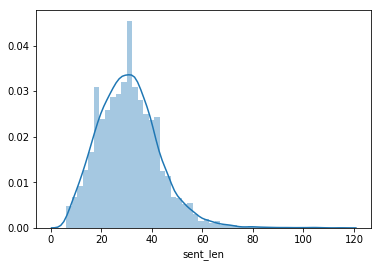

In [60]:
sns.distplot(hdn_examples.sent_len.sample(10000))

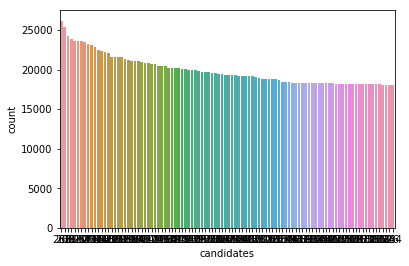

In [54]:
sns.countplot(x='candidates', data=hdn_examples, 
              order=pd.value_counts(hdn_examples.candidates).iloc[:100].index)

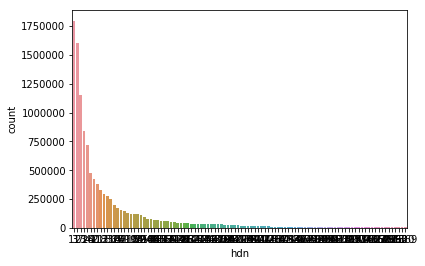

In [55]:
sns.countplot(x='hdn', data=hdn_examples, 
              order=pd.value_counts(hdn_examples.hdn).iloc[:100].index)

In [51]:
for _, row in hdn_examples.sample(n=10).iterrows():
    sent_as_ids = buffer[row['sent_start'] : row['sent_stop']]
    word_as_id = buffer[row['sent_start'] + row['word_index']]
    print(' '.join(id2word[i] for i in sent_as_ids))
    print('\tWord: "%s" at %d' %(id2word[word_as_id], ex['word']))
    for cand in id2hdn_list[row['candidates']]:
        print('\t%s' %id2synset[cand].name())
    print('\t--> %s' %id2synset[id2hdn[row['hdn']]].name())

A law enforcement official in Washington , speaking on condition of anonymity , said Lidle -- an avid pilot who earned his flying license before the start of this past season -- was aboard the single - engine aircraft when it slammed into the 30th and 31st floors of the high - rise on the Upper East Side of New York City 's borough of Manhattan .
	Word: "anonymity" at 7
	psychological_feature.n.01
	attribute.n.02
	fixed_charge.n.01
	poundage.n.01
	--> attribute.n.02
" The Japanese government has made a commitment to handle the problem of the Diaoyu Islands properly and I think they are is serious , " spokesman Shen Guofang said .
	Word: "spokesman" at 7
	person.n.01
	animal.n.01
	natural_object.n.01
	act.n.02
	communication.n.02
	happening.n.01
	--> person.n.01
" We were sent someone without any documents , no papers on him , not even a legal paper .
	Word: "someone" at 7
	person.n.01
	transgression.n.01
	falsification.n.02
	brome.n.01
	rye_grass.n.01
	--> person.n.01
Telerj net income

## Stratified sampling

In [6]:
import numpy as np
gigaword_path_pattern = '../output/gigaword-%s.2018-05-10-7d764e7.npz'
buffer_train = np.load(gigaword_path_pattern %'dev')['buffer']

In [4]:
import pandas as pd
hdn_path_pattern = '../output/gigaword-hdn-%s.2018-05-18-f48a06c.pkl'
hdn_train = pd.read_pickle(hdn_path_pattern %'dev')
hdn_train.head()

,candidates,hdn,sent_len,sent_start,sent_stop,word_index
0,1894,37,20,25,45,6
1,2715,37,20,25,45,15
2,1584,37,22,45,67,6
3,2135,37,22,45,67,20
4,1407,37,19,67,86,3


In [29]:
from tqdm import tqdm
tqdm.pandas(desc="Extracting words")
words = hdn_train.progress_apply(lambda row: buffer_train[row["sent_start"]:row["sent_stop"]][row["word_index"]], axis=1)


Extracting words:   3%|▎         | 134905/3884335 [00:07<03:19, 18792.21it/s]/Users/cumeo/Projects/spinoza/ulm-4/wsd-dynamic-sense-vector/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)

Extracting words:   5%|▍         | 178017/3884335 [00:09<03:39, 16920.94it/s]

KeyboardInterrupt: 


Extracting words:   5%|▍         | 178773/3884335 [00:27<03:38, 16920.94it/s]

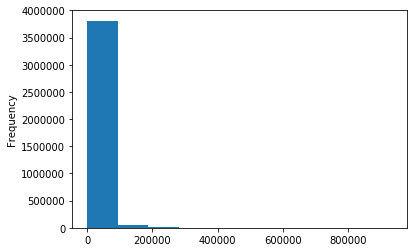

In [16]:
%matplotlib inline
words.plot('hist')

In [17]:
hdn_train['word'] = words

In [18]:
df = hdn_train.groupby('word', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))

In [24]:
print(len(df), 'vs', len(hdn_train))

450321 vs 3884335


In [25]:
len(df)/len(hdn_train)

0.11593258562920036

In [26]:
a=np.zeros((len(hdn_train)*9, 512), dtype=np.float32)